# readme
descrip: plot temp (T) and salt (S) scatter plots in Gulf of Maine <br>

update history: <br>
v1.0 DL 2021Apr12 <br>
v1.1 DL 2021May24 <br>
v1.2 DL 2021May26 <br>
v1.3 DL 2021Jun06 pivot to CESM-HR special volume and use transient minus control to account for model drift<br>

extra notes: <br>
Fig 8 of CESM-HR special volume: (a) $\Delta$T and $\Delta$S scatter plot showing HR has higher temperature increases than LR in Gulf of Maine, (b) historic and (c) future thermal and haline coefficients scatter plot showing haline coefficient is larger than thermal coefficient (more sensible to salinity change than temperature, and how thermal and haline coefficients change under future climate change scenarios  <br>
paper suggests Gulf Stream rings causes cold intermediate water (https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/JC089iC04p06575) <br>
compute in-situ temp from potential temp: https://pythonhosted.org/seawater/eos80.html <br>

# import modules

In [1]:
# general python packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import proplot as plot
# import cartopy
# cartopy.config['pre_existing_data_dir']='/scratch/group/ihesp/shared/cartopy_features'
# import cartopy.crs as ccrs
# from cartopy.mpl.geoaxes import GeoAxes
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid

# python GCM(POP) packages
# import xgcm
import pop_tools
# import xoak
# import xesmf as xe
# import seawater as sw

# dask jupyter lab packages
# import dask
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.2.130:40069")
client

Client Scheduler: tcp://10.73.2.130:40069 Dashboard: http://10.73.2.130:8787/status,Cluster Workers: 10 Cores: 10 Memory: 210.00 GB


# define paramteres

In [3]:
nlon1_g16_NA, nlon2_g16_NA = 260, 321
nlat1_g16_NA, nlat2_g16_NA = 200+50, 370

# === GM: Gulf of Maine ===
# see Plot2FindNorthAtlanticGulfMainenlatnlonIndex_2021May31.ipynb for nlon, nlat index
lon1_GMa, lon2_GMa = -71+360, -66+360 
lat1_GMa, lat2_GMa = 42, 45

nlon1_t12_GMa, nlon2_t12_GMa = 50+300, 800-300
nlat1_t12_GMa, nlat2_t12_GMa = 1200+400, 2100-400
# ==========================

# === GMe: Gulf of Mexico ===
lon1_GMe, lon2_GMe = -95+360, -85+360 
lat1_GMe, lat2_GMe = 23, 28

nlon1_t12_GMe, nlon2_t12_GMe = 50, 350 
nlat1_t12_GMe, nlat2_t12_GMe = 1350, 1650
# ============================


outdir='/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'InSituDensFutureMinusHistGulfMaineMexico_2021Jun16.png'

read transient HR files

In [4]:
mons = np.arange(1,13)
chunks_HR = {'nlat':400,'nlon':300}

indir1a_TH = ('/ihesp/archive/'
          'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/monthly/')
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

yrs0_TH = np.arange(1850,1850+1) 
# B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1928-06.nc
infiles0_TH = [indir1a_TH + prefix1a_TH + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs0_TH, mons)]

yrs1a_TH = np.arange(2001,2005+1) 
# B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1928-06.nc
infiles1a_TH = [indir1a_TH + prefix1a_TH + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1a_TH, mons)]
infiles1a_TH

indir2_TH = ('/ihesp/archive/'
          'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/monthly/')
prefix2_TH = 'cmpr_B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
yrs1b_TH = np.arange(2006,2020+1) 
yrs2_TH = np.arange(2081,2100+1)
# cmpr_B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.2053-02.nc
infiles1b_TH = [indir2_TH + prefix2_TH + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1b_TH, mons)]
infiles2_TH = [indir2_TH + prefix2_TH + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs2_TH, mons)]

infiles1_TH = infiles1a_TH + infiles1b_TH

In [5]:
ds00_TH=xr.open_dataset(infiles0_TH[0])

keeplist=['TEMP','SALT','PD','time','z_t','TLONG','TLAT']

droplist_TH=list(ds00_TH.variables)
for i in keeplist:
    droplist_TH.remove(i)
# droplist

# ds0_TH = xr.open_mfdataset(infiles0_TH, compat="override", combine="by_coords", 
#                        data_vars="minimal", coords="minimal", chunks=chunks_HR, 
#                        drop_variables=droplist_TH, parallel=True)
# time0_s_TH = ds0_TH.time.to_pandas().index.shift(-1,'M')
# ds0_TH = ds0_TH.assign_coords(time=time0_s_TH)

ds1_TH = xr.open_mfdataset(infiles1_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       drop_variables=droplist_TH, parallel=True)
# time1_s_TH = ds1_TH.time.to_pandas().index.shift(-1,'M')
# ds1_TH = ds1_TH.assign_coords(time=time1_s_TH)

ds2_TH = xr.open_mfdataset(infiles2_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       drop_variables=droplist_TH, parallel=True)

# time2_s_TH = ds2_TH.time.to_pandas().index.shift(-1,'M')
# ds2_TH = ds2_TH.assign_coords(time=time2_s_TH)

ds2_TH

<xarray.Dataset>
Dimensions:         (nlat: 2400, nlon: 3600, time: 240, z_t: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time            (time) object 2081-02-01 00:00:00 ... 2101-01-01 00:00:00
  * z_t             (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    TLONG           (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT            (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, z_w_bot, z_w_top
Data variables:
    TEMP            (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    SALT            (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    TEND_TEMP       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    TEND_SALT       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    KPP_SRC_TEMP    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    DIA_IMPVF_TEMP  (time, z_w_bot, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    WTT             (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    WTS             (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    PD              (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    QSW_3D          (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-06-05 at 12:47:55.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  17101331
    tavg_sum:      2678400.0

read control HR

In [6]:
indir_CH = ('/ihesp/archive/'
          'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/monthly/')
prefix_CH = 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0'
yrs1_CH = np.arange(401, 420+1) 
# B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1928-06.nc
infiles1_CH = [indir_CH + prefix_CH + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1_CH, mons)]
infiles1_CH

# 250-->1850, 500-->2100
# 401-->2001, 420-->2020, 481-->2081, (1850-250=1600, transient year minus 1600 is control year)

yrs2_CH = np.arange(481, 500+1)
infiles2_CH = [indir_CH + prefix_CH + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs2_CH, mons)]

In [7]:
ds00_CH=xr.open_dataset(infiles1_CH[0])

keeplist=['TEMP','SALT','PD','time','z_t','TLONG','TLAT']

droplist_CH=list(ds00_CH.variables)
for i in keeplist:
    droplist_CH.remove(i)
# droplist

ds1_CH = xr.open_mfdataset(infiles1_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       drop_variables=droplist_CH, parallel=True)

# print(ds1_CH.time)
# time1_s_CH = ds1_CH.time.to_pandas().index.shift(1850-250,'Y') # 1850 --> 250
# ds1_CH = ds1_CH.assign_coords(time=time1_s_CH)
ds1_CH

ds2_CH = xr.open_mfdataset(infiles2_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       drop_variables=droplist_CH, parallel=True)

# print(ds2_CH.time)
# time2_s_CH = ds2_CH.time.to_pandas().index.shift(1850-250,'Y') # 1850 --> 250
# ds2_CH = ds2_CH.assign_coords(time=time2_s_CH)
ds2_CH

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, time: 240, z_t: 62)
Coordinates:
  * time     (time) object 0481-02-01 00:00:00 ... 0501-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    SALT     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
    PD       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-11 at 07:59:15.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  104788931
    tavg_sum:      2678400.0

read transient LR

In [8]:
chunks_LR = {'nlat':384,'nlon':320}

indir1a_TL = ('/ihesp/archive/'
          'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/')
prefix1a_TL = 'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.'

yrs0_TL = np.arange(1850,1850+1) 
# cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1899-04.nc
infiles0_TL = [indir1a_TL + prefix1a_TL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs0_TL, mons)]

yrs1a_TL = np.arange(2001,2005+1) 
# cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1899-04.nc
infiles1a_TL = [indir1a_TL + prefix1a_TL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1a_TL, mons)]
infiles1a_TL

indir2_TL = ('/ihesp/archive/'
          'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/ocn/monthly/')
prefix2_TL = 'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.'
yrs1b_TL = np.arange(2006,2013+1) # no 2014 yr due to missing 2014-01 nc file

# cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2055-12.nc
infiles1b_TL = [indir2_TL + prefix2_TL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1b_TL, mons)]

yrs1c_TL = np.arange(2015,2020+1) 
infiles1c_TL = [indir2_TL + prefix2_TL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1c_TL, mons)]

infiles1_TL = infiles1a_TL + infiles1b_TL + infiles1c_TL

yrs2_TL = np.arange(2081,2100+1)
infiles2_TL = [indir2_TL + prefix2_TL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs2_TL, mons)]

In [9]:
ds00_TL=xr.open_dataset(infiles0_TL[0])

keeplist=['TEMP','SALT','PD','time','z_t','TLONG','TLAT']
    
droplist_TL=list(ds00_TL.variables)
for i in keeplist:
    droplist_TL.remove(i)
# droplist

# ds0_TL = xr.open_mfdataset(infiles0_TL, compat="override", combine="by_coords", 
#                        data_vars="minimal", coords="minimal", chunks=chunks_LR, 
#                        drop_variables=droplist_TL, parallel=True)
# time0_s_TL = ds0_TL.time.to_pandas().index.shift(-1,'M')
# ds0_TL = ds0_TL.assign_coords(time=time0_s_TL)

ds1_TL = xr.open_mfdataset(infiles1_TL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, 
                       drop_variables=droplist_TL, parallel=True)
# time1_s_TL = ds1_TL.time.to_pandas().index.shift(-1,'M')
# ds1_TL = ds1_TL.assign_coords(time=time1_s_TL)

ds2_TL = xr.open_mfdataset(infiles2_TL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, 
                       drop_variables=droplist_TL, parallel=True)
# time2_s_TL = ds2_TL.time.to_pandas().index.shift(-1,'M')
# ds2_TL = ds2_TL.assign_coords(time=time2_s_TL)

ds2_TL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 240, z_t: 60)
Coordinates:
  * time     (time) object 2081-02-01 00:00:00 ... 2101-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    SALT     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    PD       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:         B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-05-30 at 15:35:59.2
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  685125
    tavg_sum:      2678400.0

read control LR 

In [10]:
indir_CL = ('/ihesp/archive/'
          'B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/')
prefix_CL = 'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0'
yrs1_raw_CL = np.arange(401,420+1)
yrs1_CL = np.delete(yrs1_raw_CL,[401-401, 417-401])
print(yrs1_raw_CL)
print(yrs1_CL)
# yr: 374, 398, 401, 417, 445 have missing monthly data files, do not use them
# B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1928-06.nc
infiles1_CL = [indir_CL + prefix_CL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs1_CL, mons)]
infiles1_CL

# 250-->1850, 500-->2100
# 401-->2001, 420-->2020, 481-->2081, (1850-250=1600, transient year minus 1600 is control year)
yrs2_CL = np.arange(481, 500+1)
infiles2_CL = [indir_CL + prefix_CL + str(iyr) +'-'+str(imon).zfill(2)+ '.nc' 
               for iyr, imon in product(yrs2_CL, mons)]

[401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420]
[402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 418 419 420]


In [11]:
ds00_CL=xr.open_dataset(infiles1_CL[0])

keeplist=['TEMP','SALT','PD','time','z_t','TLONG','TLAT']

droplist_CL=list(ds00_CL.variables)
for i in keeplist:
    droplist_CL.remove(i)
# droplist

ds1_CL= xr.open_mfdataset(infiles1_CL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       drop_variables=droplist_CL, parallel=True)

# print(ds1_CL.time)
# time1_s_CL = ds1_CL.time.to_pandas().index.shift(1850-250,'Y') # 1850 --> 250
# ds1_CL = ds1_CL.assign_coords(time=time1_s_CL)
# ds1_CL

ds2_CL = xr.open_mfdataset(infiles2_CL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       drop_variables=droplist_CL, parallel=True)

# print(ds2_CL.time)
# time2_s_CL = ds2_CL.time.to_pandas().index.shift(1850-250,'Y') # 1850 --> 250
# ds2_CL = ds2_CL.assign_coords(time=time2_s_CL)
ds2_CL

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 240, z_t: 60)
Coordinates:
  * time     (time) object 0481-02-01 00:00:00 ... 0501-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 300), meta=np.ndarray>
    SALT     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 300), meta=np.ndarray>
    PD       (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-05-24 at 06:39:54.6
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  4380750
    tavg_sum:      2678400.0

read grid files

In [12]:
infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_NA_g16 = ds_g16.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

TLAT_NA_LR = ds_NA_g16.TLAT
TLON_NA_LR = ds_NA_g16.TLONG
TAREA_NA_LR = ds_NA_g16.TAREA


infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/'
'SupplementaryFiles4POP/POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_GMa_t12 = ds_t12.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))
ds_GMe_t12 = ds_t12.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

TLAT_GMa_HR = ds_GMa_t12.TLAT
TLON_GMa_HR = ds_GMa_t12.TLONG
TAREA_GMa_HR = ds_GMa_t12.TAREA

TLAT_GMe_HR = ds_GMe_t12.TLAT
TLON_GMe_HR = ds_GMe_t12.TLONG
TAREA_GMe_HR = ds_GMe_t12.TAREA

In [13]:
# pd1_NA_TL = ds1_TL.PD.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
#                                nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

# pd1_GMe_TH = ds1_TH.PD.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
#                                nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

# pd1_GMem_TL = pd1_NA_TL.where((TLAT_NA_LR>lat1_GMe) & (TLAT_NA_LR<lat2_GMe) & 
#                                 (TLON_NA_LR>lon1_GMe) & (TLON_NA_LR<lon2_GMe), np.nan) # GMem: Gulf of Mexico mask

# pd1_GMem_TH = pd1_GMe_TH.where((TLAT_GMe_HR>lat1_GMe) & (TLAT_GMe_HR<lat2_GMe) & 
#                                 (TLON_GMe_HR>lon1_GMe) & (TLON_GMe_HR<lon2_GMe), np.nan) # GMem: Gulf of Mexico mask

# (pd1_GMem_TL*1000-1000).mean(('time','nlat','nlon')).plot(color='b',y='z_t',yincrease=False)
# (pd1_GMem_TH*1000-1000).mean(('time','nlat','nlon')).plot(color='r',y='z_t',yincrease=False)

# data analysis 

LR - Gulf of Maine and Mexico

In [14]:
%%time
temp1_NA_TL = ds1_TL.TEMP.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

temp2_NA_TL = ds2_TL.TEMP.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

temp1_NA_CL = ds1_CL.TEMP.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

temp2_NA_CL = ds2_CL.TEMP.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))


salt1_NA_TL = ds1_TL.SALT.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

salt2_NA_TL = ds2_TL.SALT.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

salt1_NA_CL = ds1_CL.SALT.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

salt2_NA_CL = ds2_CL.SALT.isel(nlon=slice(nlon1_g16_NA, nlon2_g16_NA),
                               nlat=slice(nlat1_g16_NA, nlat2_g16_NA))

rho1_NA_TL = pop_tools.eos(salt1_NA_TL, temp1_NA_TL, depth=temp1_NA_TL.z_t*1e-2)
rho2_NA_TL = pop_tools.eos(salt2_NA_TL, temp2_NA_TL, depth=temp2_NA_TL.z_t*1e-2)
rho1_NA_CL = pop_tools.eos(salt1_NA_CL, temp1_NA_CL, depth=temp1_NA_CL.z_t*1e-2)
rho2_NA_CL = pop_tools.eos(salt2_NA_CL, temp2_NA_CL, depth=temp2_NA_CL.z_t*1e-2)

rho1_NA_TL = rho1_NA_TL.mean('time').compute()
rho2_NA_TL = rho2_NA_TL.mean('time').compute()

rho1_NA_CL = rho1_NA_CL.mean('time').compute()
rho2_NA_CL = rho2_NA_CL.mean('time').compute()

drho_NA_TL = (rho2_NA_TL-rho1_NA_TL) - (rho2_NA_CL-rho1_NA_CL)

# mask out unnecessary areas of Gulf of Maine and Mexico
rho1_GMam_TL = rho1_NA_TL.where((TLAT_NA_LR>lat1_GMa) & (TLAT_NA_LR<lat2_GMa) & 
                                (TLON_NA_LR>lon1_GMa) & (TLON_NA_LR<lon2_GMa), np.nan) # GMam: Gulf of Maine mask
rho1_GMem_TL = rho1_NA_TL.where((TLAT_NA_LR>lat1_GMe) & (TLAT_NA_LR<lat2_GMe) & 
                                (TLON_NA_LR>lon1_GMe) & (TLON_NA_LR<lon2_GMe), np.nan) # GMem: Gulf of Mexico mask

drho_GMam_TL = drho_NA_TL.where((TLAT_NA_LR>lat1_GMa) & (TLAT_NA_LR<lat2_GMa) & 
                                (TLON_NA_LR>lon1_GMa) & (TLON_NA_LR<lon2_GMa), np.nan) # GMam: Gulf of Maine mask
drho_GMem_TL = drho_NA_TL.where((TLAT_NA_LR>lat1_GMe) & (TLAT_NA_LR<lat2_GMe) & 
                                (TLON_NA_LR>lon1_GMe) & (TLON_NA_LR<lon2_GMe), np.nan) # GMem: Gulf of Mexico mask

CPU times: user 8.92 s, sys: 409 ms, total: 9.32 s
Wall time: 7min 24s


HR - Gulf of Maine (GMa)

In [15]:
%%time
# === temp ===
temp1_GMa_TH = ds1_TH.TEMP.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))

temp2_GMa_TH = ds2_TH.TEMP.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))

temp1_GMa_CH = ds1_CH.TEMP.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))

temp2_GMa_CH = ds2_CH.TEMP.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))



# === salt ===
salt1_GMa_TH = ds1_TH.SALT.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))

salt2_GMa_TH = ds2_TH.SALT.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))

salt1_GMa_CH = ds1_CH.SALT.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))

salt2_GMa_CH = ds2_CH.SALT.isel(nlon=slice(nlon1_t12_GMa, nlon2_t12_GMa),
                               nlat=slice(nlat1_t12_GMa, nlat2_t12_GMa))


# === in-situ density ===
rho1_GMa_TH = pop_tools.eos(salt1_GMa_TH, temp1_GMa_TH, depth=temp1_GMa_TH.z_t*1e-2)
rho2_GMa_TH = pop_tools.eos(salt2_GMa_TH, temp2_GMa_TH, depth=temp2_GMa_TH.z_t*1e-2)
rho1_GMa_CH = pop_tools.eos(salt1_GMa_CH, temp1_GMa_CH, depth=temp1_GMa_CH.z_t*1e-2)
rho2_GMa_CH = pop_tools.eos(salt2_GMa_CH, temp2_GMa_CH, depth=temp2_GMa_CH.z_t*1e-2)

rho1_GMa_TH = rho1_GMa_TH.mean('time').compute()
rho2_GMa_TH = rho2_GMa_TH.mean('time').compute()
rho1_GMa_CH = rho1_GMa_CH.mean('time').compute()
rho2_GMa_CH = rho2_GMa_CH.mean('time').compute()

drho_GMa_TH = (rho2_GMa_TH-rho1_GMa_TH) - (rho2_GMa_CH-rho1_GMa_CH)

# mask out unnecessary areas of Gulf of Maine
rho1_GMam_TH = rho1_GMa_TH.where((TLAT_GMa_HR>lat1_GMa) & (TLAT_GMa_HR<lat2_GMa) & 
                                 (TLON_GMa_HR>lon1_GMa) & (TLON_GMa_HR<lon2_GMa), np.nan) # GMam: Gulf of Maine mask

drho_GMam_TH = drho_GMa_TH.where((TLAT_GMa_HR>lat1_GMa) & (TLAT_GMa_HR<lat2_GMa) & 
                                 (TLON_GMa_HR>lon1_GMa) & (TLON_GMa_HR<lon2_GMa), np.nan) # GMam: Gulf of Maine mask

CPU times: user 27 s, sys: 824 ms, total: 27.8 s
Wall time: 9min 8s


Gulf of Mexico (GMe)

In [16]:
%%time
# === temp ===
temp1_GMe_TH = ds1_TH.TEMP.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

temp2_GMe_TH = ds2_TH.TEMP.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

temp1_GMe_CH = ds1_CH.TEMP.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

temp2_GMe_CH = ds2_CH.TEMP.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))


# === salt ===
salt1_GMe_TH = ds1_TH.SALT.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

salt2_GMe_TH = ds2_TH.SALT.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

salt1_GMe_CH = ds1_CH.SALT.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))

salt2_GMe_CH = ds2_CH.SALT.isel(nlon=slice(nlon1_t12_GMe, nlon2_t12_GMe),
                               nlat=slice(nlat1_t12_GMe, nlat2_t12_GMe))


# === in-situ density ===
rho1_GMe_TH = pop_tools.eos(salt1_GMe_TH, temp1_GMe_TH, depth=temp1_GMe_TH.z_t*1e-2)
rho2_GMe_TH = pop_tools.eos(salt2_GMe_TH, temp2_GMe_TH, depth=temp2_GMe_TH.z_t*1e-2)
rho1_GMe_CH = pop_tools.eos(salt1_GMe_CH, temp1_GMe_CH, depth=temp1_GMe_CH.z_t*1e-2)
rho2_GMe_CH = pop_tools.eos(salt2_GMe_CH, temp2_GMe_CH, depth=temp2_GMe_CH.z_t*1e-2)

rho1_GMe_TH = rho1_GMe_TH.mean('time').compute()
rho2_GMe_TH = rho2_GMe_TH.mean('time').compute()
rho1_GMe_CH = rho1_GMe_CH.mean('time').compute()
rho2_GMe_CH = rho2_GMe_CH.mean('time').compute()

drho_GMe_TH = (rho2_GMe_TH-rho1_GMe_TH) - (rho2_GMe_CH-rho1_GMe_CH)

# mask out unnecessary areas of Gulf of Mexico
rho1_GMem_TH = rho1_GMe_TH.where((TLAT_GMe_HR>lat1_GMe) & (TLAT_GMe_HR<lat2_GMe) & 
                                 (TLON_GMe_HR>lon1_GMe) & (TLON_GMe_HR<lon2_GMe), np.nan) # GMem: Gulf of Mexico mask

drho_GMem_TH = drho_GMe_TH.where((TLAT_GMe_HR>lat1_GMe) & (TLAT_GMe_HR<lat2_GMe) & 
                                (TLON_GMe_HR>lon1_GMe) & (TLON_GMe_HR<lon2_GMe), np.nan) # GMem: Gulf of Mexico mask

CPU times: user 1min 5s, sys: 4.49 s, total: 1min 9s
Wall time: 12min 6s


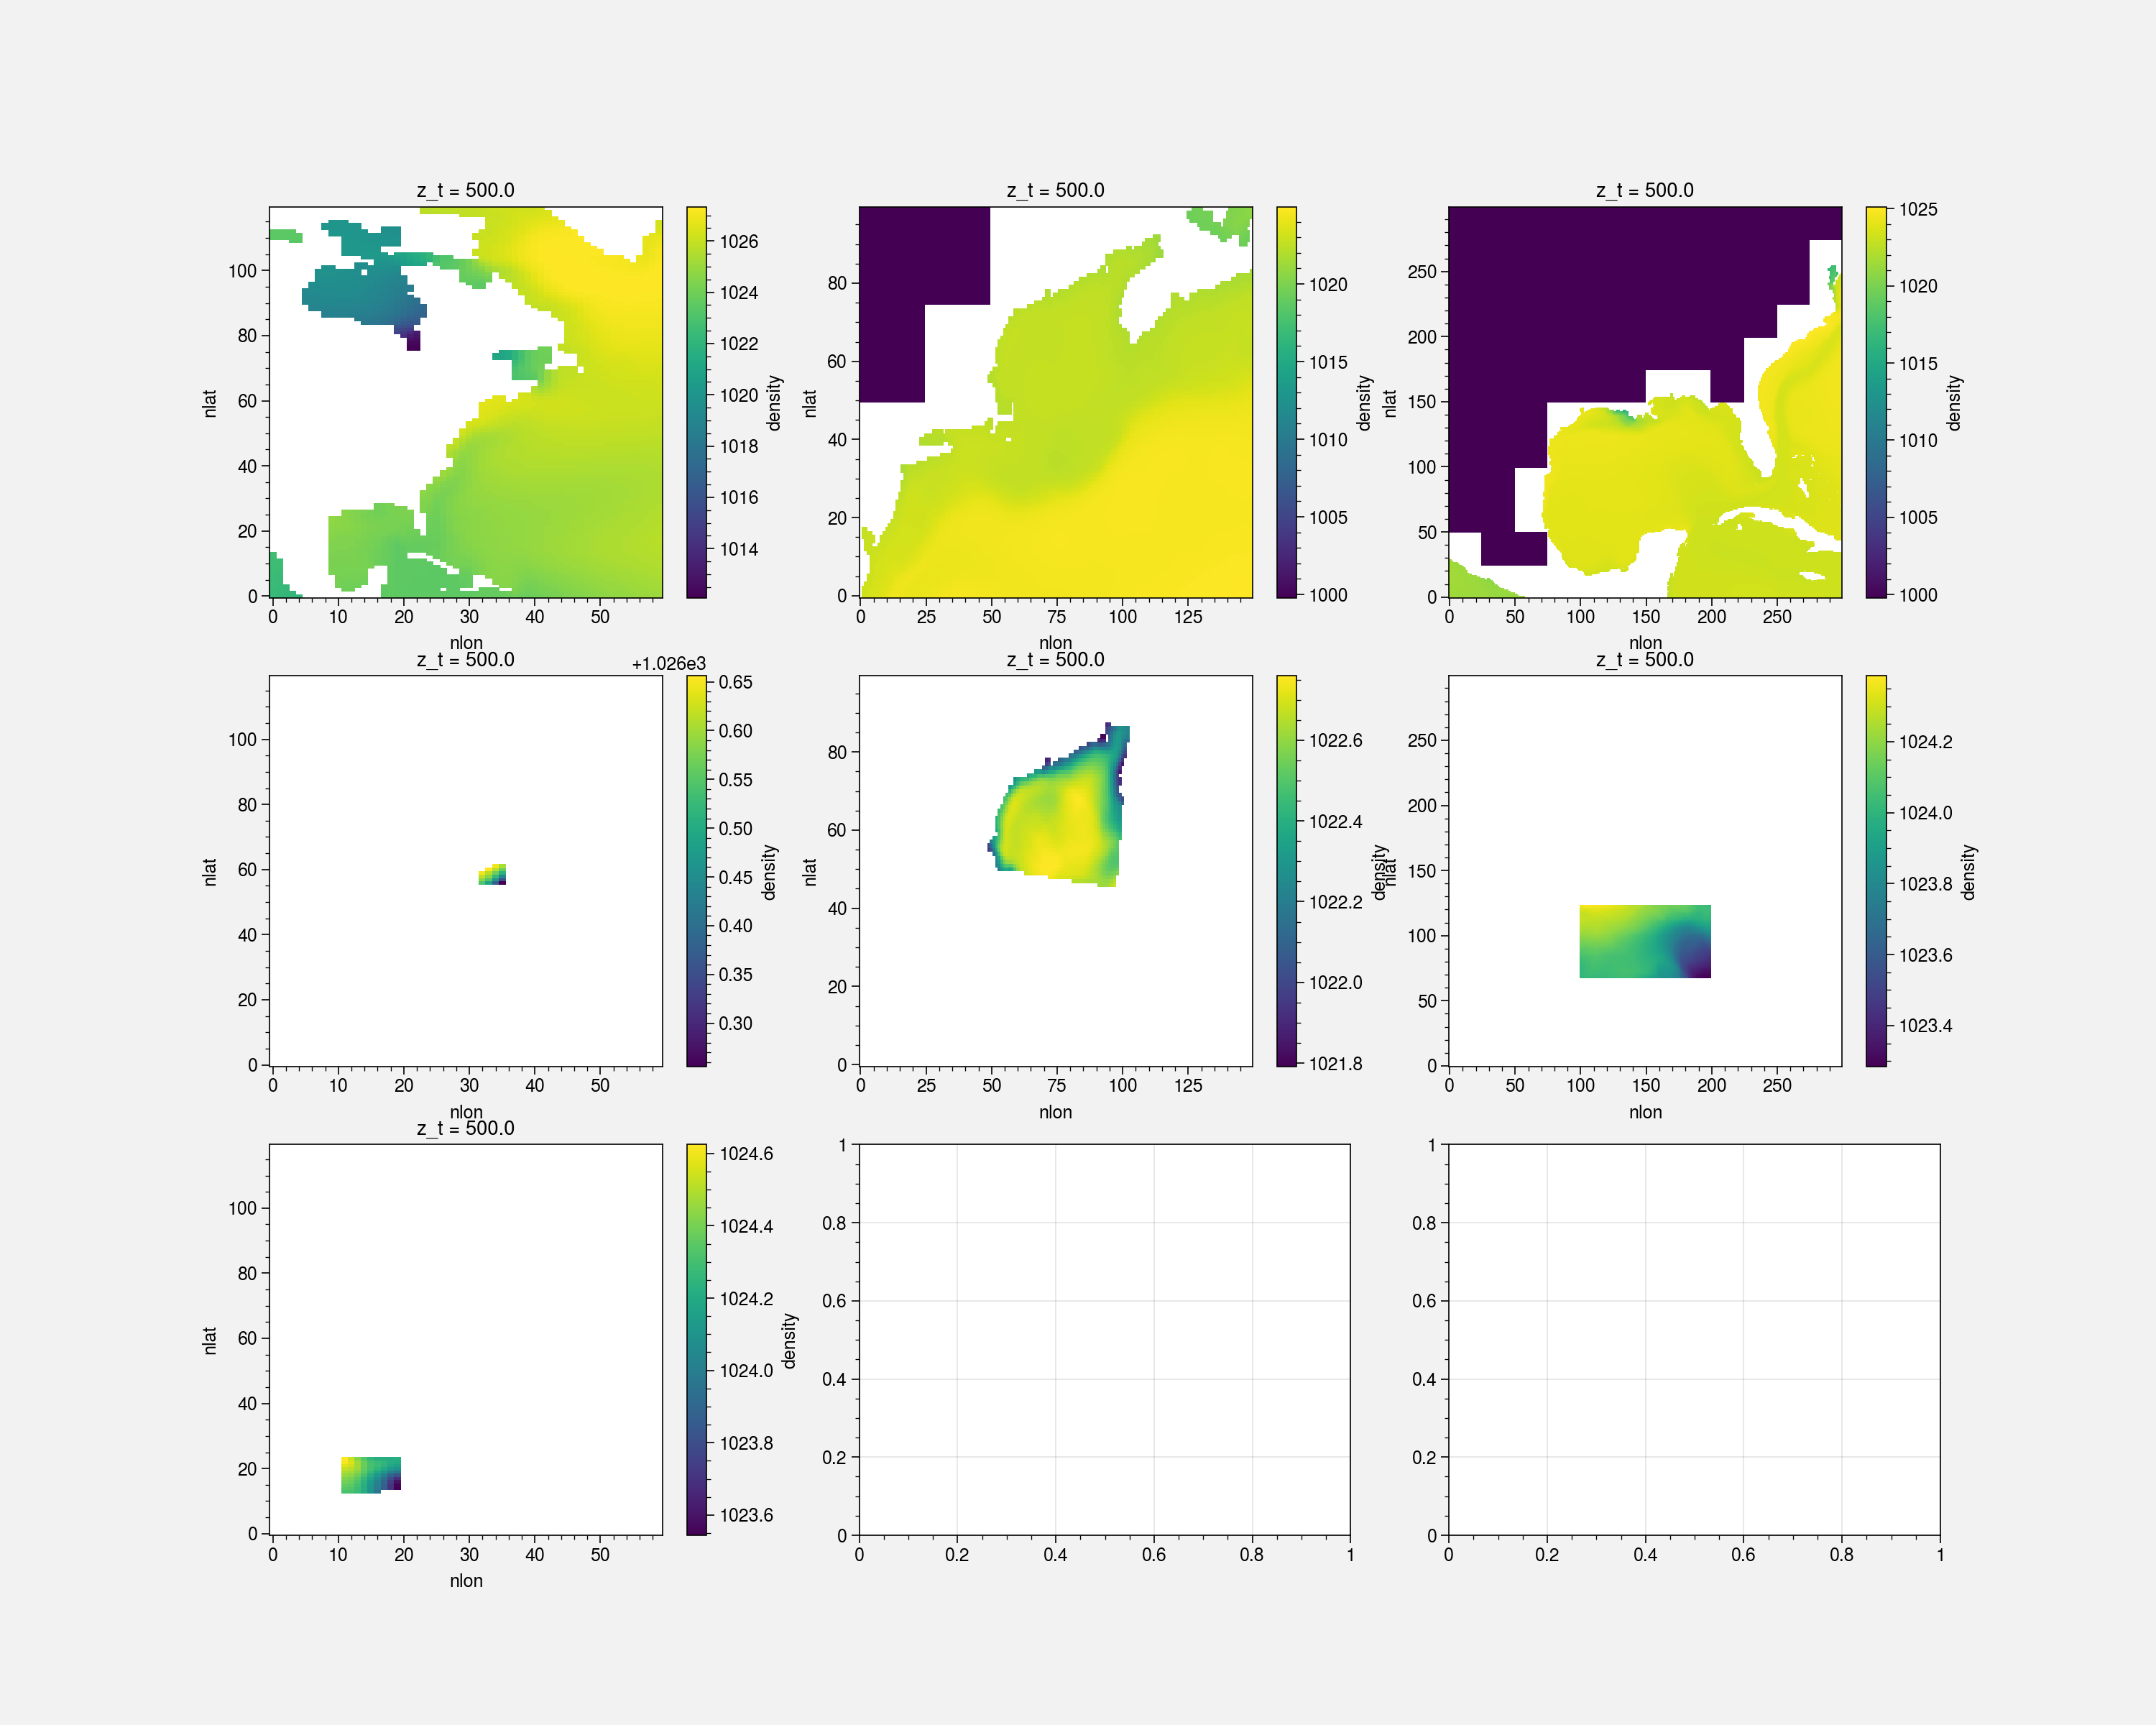

In [17]:
fig, axs = plt.subplots(3,3,figsize=(15,12))

rho1_NA_TL.isel(z_t=0).plot(ax=axs[0, 0])
rho1_GMa_TH.isel(z_t=0).plot(ax=axs[0, 1])
rho1_GMe_TH.isel(z_t=0).plot(ax=axs[0, 2])

rho1_GMam_TL.isel(z_t=0).plot(ax=axs[1, 0])
rho1_GMam_TH.isel(z_t=0).plot(ax=axs[1, 1])
rho1_GMem_TH.isel(z_t=0).plot(ax=axs[1, 2])

rho1_GMem_TL.isel(z_t=0).plot(ax=axs[2, 0])

In [18]:
# fig, axs = plt.subplots(2,2,figsize=(10,10))
# rho1_GMam_TH.isel(z_t=0).plot(ax=axs[0, 0])
# rho1_GMam_TL.isel(z_t=0).plot(ax=axs[0, 1])

# rho1_GMem_TH.isel(z_t=0).plot(ax=axs[1, 0])
# rho1_GMem_TL.isel(z_t=0).plot(ax=axs[1, 1])

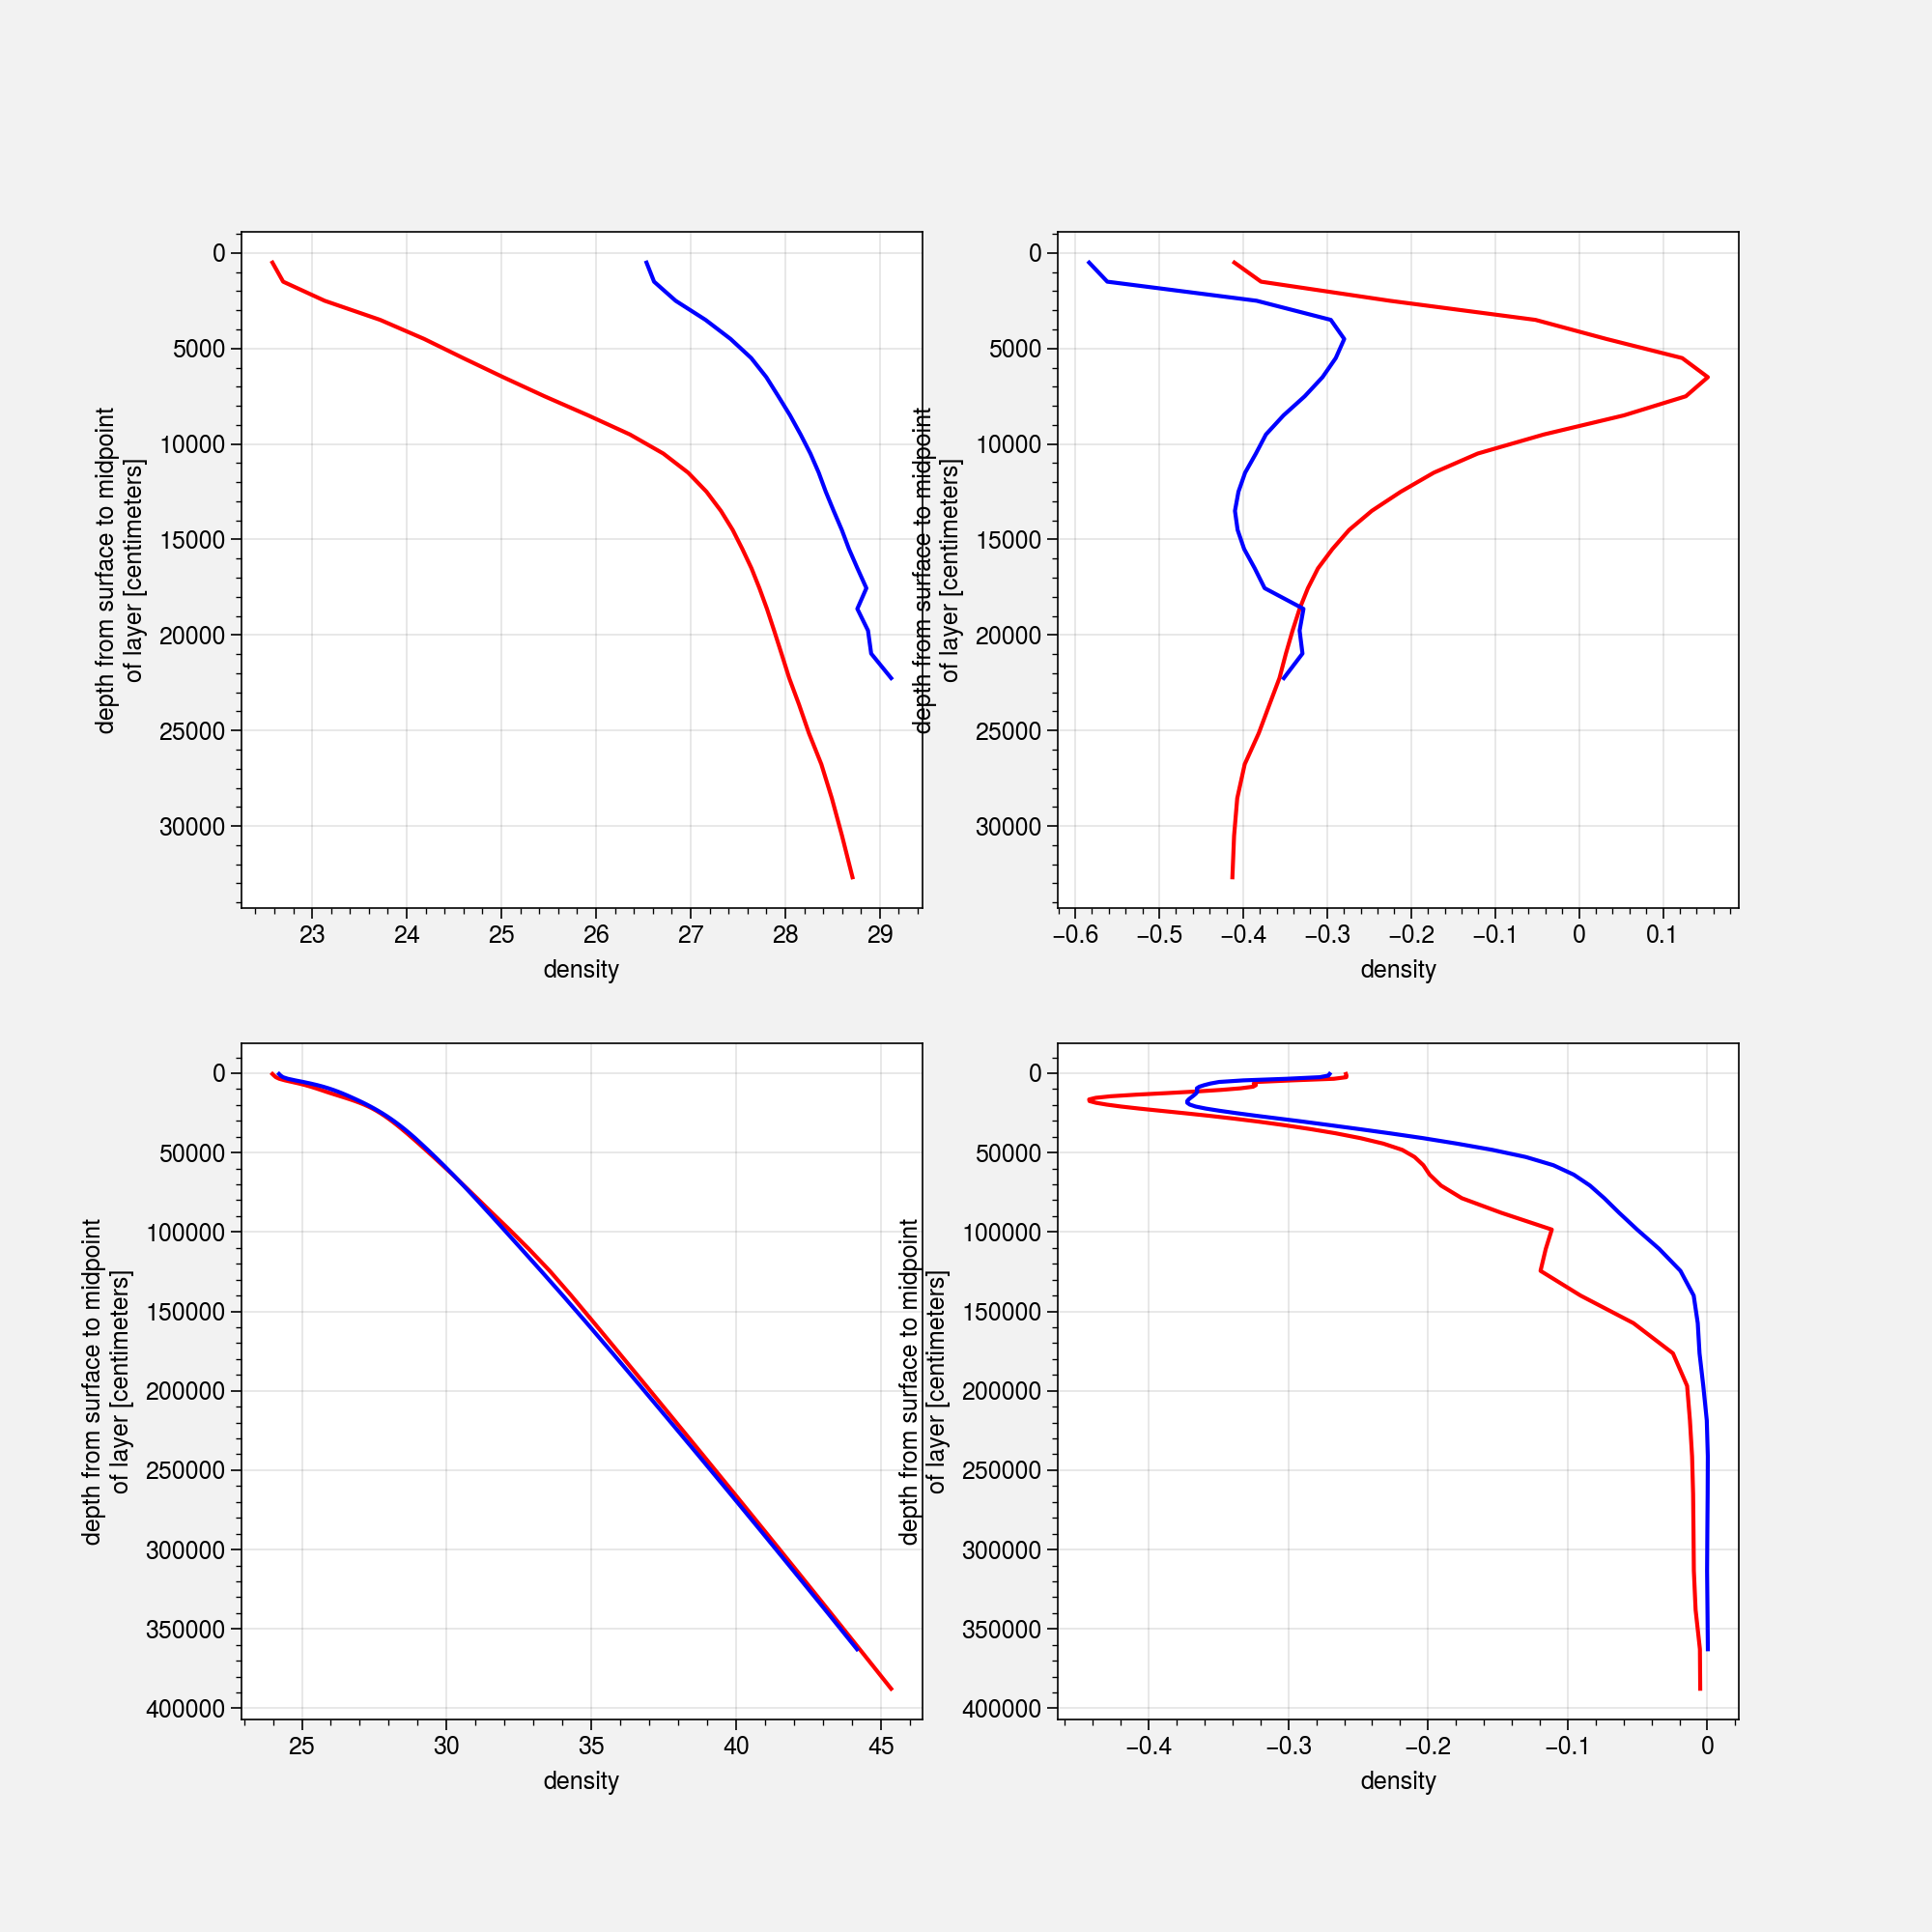

In [19]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
(rho1_GMam_TH-1000).weighted(TAREA_GMa_HR).mean(('nlon','nlat')).plot(ax=axs[0,0], color='r', y='z_t', yincrease=False)
(rho1_GMam_TL-1000).weighted(TAREA_NA_LR).mean(('nlon','nlat')).plot(ax=axs[0,0], color='b', y='z_t', yincrease=False)
drho_GMam_TH.weighted(TAREA_GMa_HR).mean(('nlon','nlat')).plot(ax=axs[0,1], color='r', y='z_t', yincrease=False)
drho_GMam_TL.weighted(TAREA_NA_LR).mean(('nlon','nlat')).plot(ax=axs[0,1], color='b', y='z_t', yincrease=False)

(rho1_GMem_TH-1000).weighted(TAREA_GMe_HR).mean(('nlon','nlat')).plot(ax=axs[1,0], color='r', y='z_t', yincrease=False)
(rho1_GMem_TL-1000).weighted(TAREA_NA_LR).mean(('nlon','nlat')).plot(ax=axs[1,0], color='b', y='z_t', yincrease=False)
drho_GMem_TH.weighted(TAREA_GMe_HR).mean(('nlon','nlat')).plot(ax=axs[1,1], color='r', y='z_t', yincrease=False)
drho_GMem_TL.weighted(TAREA_NA_LR).mean(('nlon','nlat')).plot(ax=axs[1,1], color='b', y='z_t', yincrease=False)

In [20]:
drho_GMam_sa_TH = drho_GMam_TH.weighted(TAREA_GMa_HR).mean(('nlon','nlat')) # spatial av
drho_GMam_sa_TL = drho_GMam_TL.weighted(TAREA_NA_LR).mean(('nlon','nlat'))
drho_GMem_sa_TH = drho_GMem_TH.weighted(TAREA_GMe_HR).mean(('nlon','nlat'))
drho_GMem_sa_TL = drho_GMem_TL.weighted(TAREA_NA_LR).mean(('nlon','nlat'))

# make pics

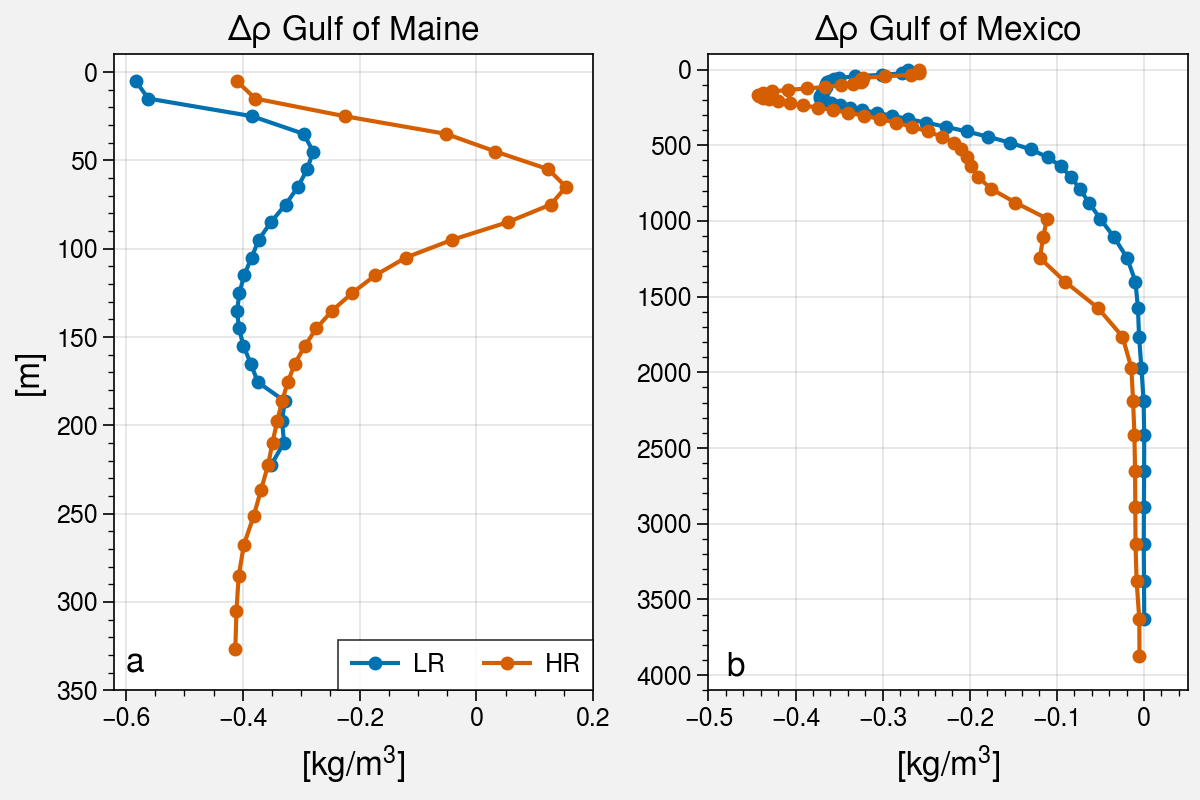

In [52]:
fig1, axs = plot.subplots(nrows=1,ncols=2,width='6in',height='4in',share=0)

m0=axs[0].plot(drho_GMam_sa_TL, drho_GMam_sa_TL.z_t/100, marker='o',markersize=4,label='LR')
m0=axs[0].plot(drho_GMam_sa_TH, drho_GMam_sa_TH.z_t/100, marker='o',markersize=4,label='HR')
axs[0].set_xlim([-0.62, 0.2])
axs[0].set_ylim([-10, 350])
axs[0].invert_yaxis()
axs[0].set_title(r'$\Delta\rho$ Gulf of Maine', fontsize=12)
axs[0].set_ylabel('[m]', fontsize=12)
axs[0].set_xlabel('[$kg/m^3$]', fontsize=12)
axs[0].legend(loc='lr')
axs[0].text(-0.6, 340, 'a', fontsize=12)

m1=axs[1].plot(drho_GMem_sa_TL, drho_GMem_sa_TL.z_t/100, marker='o',markersize=4,label='LR')
m1=axs[1].plot(drho_GMem_sa_TH, drho_GMem_sa_TH.z_t/100, marker='o',markersize=4,label='HR')
axs[1].set_xlim([-0.5, 0.05])
axs[1].set_ylim([-100, 4100])
axs[1].invert_yaxis()
axs[1].set_title(r'$\Delta\rho$ Gulf of Mexico', fontsize=12)
axs[1].set_ylabel('')
axs[1].set_xlabel('[$kg/m^3$]', fontsize=12)
axs[1].text(-0.48, 4000, 'b', fontsize=12)

fig1.savefig(pic1,bbox_inches='tight')